In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2


In [2]:
#load Dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [3]:
import numpy as np

print("y_train shape:", y_train.shape)
print("num classes:", len(np.unique(y_train)))
print("min/max label:", y_train.min(), y_train.max())

y_train shape: (50000, 1)
num classes: 100
min/max label: 0 99


In [4]:
# Convert NumPy arrays into a tf.data pipeline (yields (image, label) pairs)

ds_train = tf.data.Dataset.from_tensor_slices((X_train,y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [5]:
# Data augmentation
def data_augment(image,label):
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_hue(image, max_delta=0.2)
  image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
  image = tf.clip_by_value(image, 0.0, 1.0)

  return image, label

In [6]:
# Preprocessing
def preprocessing(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/255.0)
  image = tf.image.resize(image, (224,224))

  return image , label

In [7]:
# prepare pipline
def prepare_pip(ds, augment=False, shuffle=False):
  ds = ds.shuffle(buffer_size=10000) if shuffle else ds
  ds = ds.map(preprocessing, num_parallel_calls = tf.data.AUTOTUNE)
  ds = ds.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE) if augment else ds
  ds = ds.batch(batch_size=64)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds

In [8]:
# Preprocess the data
train_ds = prepare_pip(ds_train, augment=True, shuffle=True)
test_ds = prepare_pip(ds_test, augment=False, shuffle=False)

## Implement *ResNet-18*

In [9]:
# regularization val
wd = 1e-4

#model ResNet-18
#Input
inputs = layers.Input(shape=(224,224,3), name="image")

#stem
x= layers.Conv2D(64,(7,7), padding='same', strides=2, kernel_initializer='he_normal', kernel_regularizer=l2(wd), name="stem_conv",use_bias=False,)(inputs)
x= layers.BatchNormalization(name="stem_bn")(x)
x= layers.ReLU(name="stem_relu")(x)
x= layers.MaxPool2D((3,3), padding="same", strides=2, name="stem_pool")(x)

#Block 2_1
shortcut = x


x= layers.Conv2D(64,(3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(wd), name="conv2_1_conv1",use_bias=False)(x)
x= layers.BatchNormalization(name="conv2_1_bn1")(x)
x= layers.ReLU(name="conv2_1_relu1")(x)

x= layers.Conv2D(64,(3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(wd), name="conv2_1_conv2",use_bias=False)(x)
x= layers.BatchNormalization(name="conv2_1_bn2")(x)
x= layers.Add(name="conv2_1_add")([x, shortcut])
x= layers.ReLU(name="conv2_1_out")(x)


#Block 2_2
shortcut = x

x = layers.Conv2D( 64, (3, 3), strides=1,padding="same",kernel_initializer="he_normal",kernel_regularizer=l2(wd), name="conv2_2_conv1",use_bias=False)(x)
x= layers.BatchNormalization(name="conv2_2_bn1")(x)
x= layers.ReLU(name="conv2_2_relu1")(x)

x= layers.Conv2D(64, (3, 3), padding="same" , kernel_initializer="he_normal", kernel_regularizer=l2(wd),name="conv2_2_conv2",use_bias=False)(x)
x= layers.BatchNormalization(name="conv2_2_bn2")(x)

x= layers.Add(name="conv2_2_add")([x, shortcut])
x= layers.ReLU(name="conv2_2_out")(x)



#Block 3_1 (downsample)
shortcut = layers.Conv2D(128, (1, 1), strides=2, padding="same",kernel_initializer="he_normal",kernel_regularizer=l2(wd),name="conv3_1_skip_conv",use_bias=False)(x)
shortcut = layers.BatchNormalization(name="conv3_1_skip_bn")(shortcut)

x= layers.Conv2D(128, (3, 3),strides=2,padding="same",kernel_initializer="he_normal",kernel_regularizer=l2(wd),name="conv3_1_conv1",use_bias=False)(x)
x= layers.BatchNormalization(name="conv3_1_bn1")(x)
x= layers.ReLU(name="conv3_1_relu1")(x)

x= layers.Conv2D(128, (3, 3),padding="same",kernel_initializer="he_normal",kernel_regularizer=l2(wd),name="conv3_1_conv2",use_bias=False)(x)
x= layers.BatchNormalization(name="conv3_1_bn2")(x)

x= layers.Add(name="conv3_1_add")([x, shortcut])
x= layers.ReLU(name="conv3_1_out")(x)

#Block 3_2
shortcut= x

x= layers.Conv2D(128, (3, 3),padding="same",kernel_initializer="he_normal",kernel_regularizer=l2(wd),name="conv3_2_conv1",use_bias=False)(x)
x= layers.BatchNormalization(name="conv3_2_bn1")(x)
x= layers.ReLU(name="conv3_2_relu1")(x)

x= layers.Conv2D(128, (3, 3),strides=1,padding="same",kernel_initializer="he_normal",kernel_regularizer=l2(wd),name="conv3_2_conv2",use_bias=False
)(x)
x= layers.BatchNormalization(name="conv3_2_bn2")(x)

x= layers.Add(name="conv3_2_add")([x, shortcut])
x= layers.ReLU(name="conv3_2_out")(x)

# conv4_x (256) : 2 blocks (first downsamples)

#downsample , # Block 4_1
shortcut = layers.Conv2D(256, (1, 1), strides=2, padding="same",kernel_initializer="he_normal", kernel_regularizer=l2(wd), name="conv4_1_skip_conv", use_bias=False)(x)
shortcut = layers.BatchNormalization(name="conv4_1_skip_bn")(shortcut)

x= layers.Conv2D(256, (3, 3), strides=2, padding="same",kernel_initializer="he_normal", kernel_regularizer=l2(wd), name="conv4_1_conv1", use_bias=False)(x)
x= layers.BatchNormalization(name="conv4_1_bn1")(x)
x= layers.ReLU(name="conv4_1_relu1")(x)
x= layers.Conv2D(256, (3, 3), strides=1, padding="same",kernel_initializer="he_normal", kernel_regularizer=l2(wd), name="conv4_1_conv2", use_bias=False)(x)
x= layers.BatchNormalization(name="conv4_1_bn2")(x)
x= layers.Add(name="conv4_1_add")([x, shortcut])
x= layers.ReLU(name="conv4_1_out")(x)

# Block 4_2
shortcut = x
x= layers.Conv2D(256, (3, 3), strides=1, padding="same", use_bias=False,
                  kernel_initializer="he_normal", kernel_regularizer=l2(wd), name="conv4_2_conv1")(x)
x= layers.BatchNormalization(name="conv4_2_bn1")(x)
x= layers.ReLU(name="conv4_2_relu1")(x)
x= layers.Conv2D(256, (3, 3), strides=1, padding="same",kernel_initializer="he_normal", kernel_regularizer=l2(wd), name="conv4_2_conv2",use_bias=False)(x)
x = layers.BatchNormalization(name="conv4_2_bn2")(x)
x = layers.Add(name="conv4_2_add")([x, shortcut])
x = layers.ReLU(name="conv4_2_out")(x)


# conv5_x (512) : 2 blocks (first downsamples)
#downsample , # Block 5_1

shortcut = layers.Conv2D(512, (1, 1), strides=2, padding="same",kernel_initializer="he_normal", kernel_regularizer=l2(wd), name="conv5_1_skip_conv",use_bias=False)(x)
shortcut = layers.BatchNormalization(name="conv5_1_skip_bn")(shortcut)

x= layers.Conv2D(512, (3, 3), strides=2, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(wd), name="conv5_1_conv1",use_bias=False)(x)
x= layers.BatchNormalization(name="conv5_1_bn1")(x)
x= layers.ReLU(name="conv5_1_relu1")(x)
x= layers.Conv2D(512, (3, 3), strides=1, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(wd), name="conv5_1_conv2",use_bias=False)(x)
x= layers.BatchNormalization(name="conv5_1_bn2")(x)
x= layers.Add(name="conv5_1_add")([x, shortcut])
x= layers.ReLU(name="conv5_1_out")(x)

# Block 5_2
shortcut = x
x= layers.Conv2D(512, (3, 3), strides=1, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(wd), name="conv5_2_conv1",use_bias=False)(x)
x= layers.BatchNormalization(name="conv5_2_bn1")(x)
x= layers.ReLU(name="conv5_2_relu1")(x)
x= layers.Conv2D(512, (3, 3), strides=1, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(wd), name="conv5_2_conv2",use_bias=False)(x)
x= layers.BatchNormalization(name="conv5_2_bn2")(x)
x= layers.Add(name="conv5_2_add")([x, shortcut])
x= layers.ReLU(name="conv5_2_out")(x)


x = layers.GlobalAveragePooling2D(name="gap")(x)
outputs = layers.Dense(100, activation="softmax", name="pred")(x)

model = tf.keras.Model(inputs, outputs, name="ResNet18_CIFAR100_224")

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "ResNet18_CIFAR100_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      9,408 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu (ReLU)    │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_pool           │ (None, 56, 56,    │          0 │ stem_relu[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_conv1       │ (None, 56, 56,    │     36,864 │ stem_pool[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_bn1         │ (None, 56, 56,    │        256 │ conv2_1_conv1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_relu1       │ (None, 56, 56,    │          0 │ conv2_1_bn1[0][0] │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_conv2       │ (None, 56, 56,    │     36,864 │ conv2_1_relu1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_bn2         │ (None, 56, 56,    │        256 │ conv2_1_conv2[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_add (Add)   │ (None, 56, 56,    │          0 │ conv2_1_bn2[0][0… │
│                     │ 64)               │            │ stem_pool[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_out (ReLU)  │ (None, 56, 56,    │          0 │ conv2_1_add[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2_conv1       │ (None, 56, 56,    │     36,864 │ conv2_1_out[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2_bn1         │ (None, 56, 56,    │        256 │ conv2_2_conv1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2_relu1       │ (None, 56, 56,    │          0 │ conv2_2_bn1[0][0] │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2_conv2       │ (None, 56, 56,    │     36,864 │ conv2_2_relu1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2_bn2         │ (None, 56, 56,    │        256 │ conv2_2_conv2[0]

 Total params: 11,237,412 (42.87 MB)

 Trainable params: 11,227,812 (42.83 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [10]:
# callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-5
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=8, restore_best_weights=True
)
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=test_ds,
    callbacks=callbacks
)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 199s 223ms/step - accuracy: 0.0882 - loss: 5.0502 - val_accuracy: 0.1900 - val_loss: 4.4113 - learning_rate: 1.0000e-04
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 164s 209ms/step - accuracy: 0.2359 - loss: 4.0717 - val_accuracy: 0.3080 - val_loss: 3.6724 - learning_rate: 1.0000e-04
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 164s 209ms/step - accuracy: 0.3465 - loss: 3.4842 - val_accuracy: 0.3724 - val_loss: 3.3584 - learning_rate: 1.0000e-04
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 163s 209ms/step - accuracy: 0.4237 - loss: 3.1029 - val_accuracy: 0.3872 - val_loss: 3.2588 - learning_rate: 1.0000e-04
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 163s 209ms/step - accuracy: 0.4814 - loss: 2.8297 - val_accuracy: 0.4250 - val_loss: 3.0634 - learning_rate: 1.0000e-04
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 163s 209ms/step - accuracy: 0.5318 - loss: 2.5985 - val_accuracy: 0.4575 - val_loss: 2.9139 - learning_rate: 1.0000e-04
Epoch 7/100
782/782 ━━━━━━━━━━━━━━

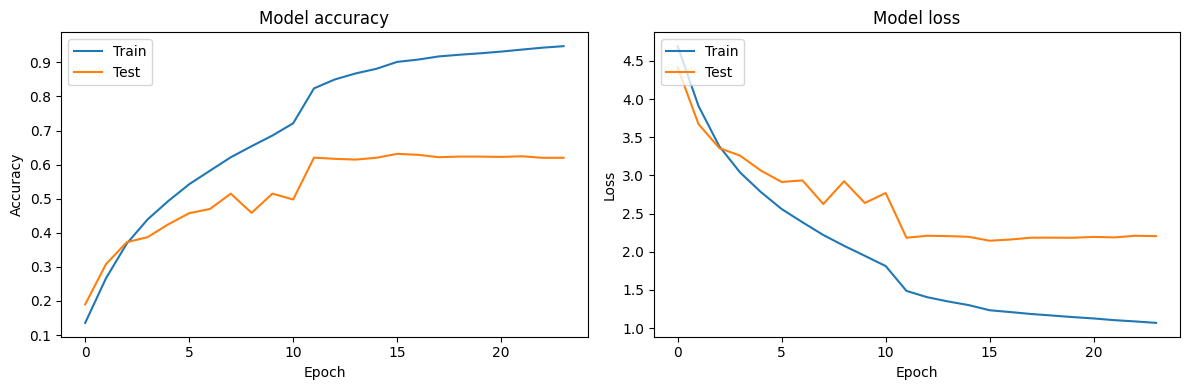

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()